# Introduction

We are going to put to good use what we learn in the previous notebook analyzing a real book.

You can download the book here: https://www.gutenberg.org/ebooks/345



In [1]:
import spacy
import numpy as np
nlp = spacy.load('en_core_web_lg')
# This is what matcher print when there is no object!
from spacy.matcher import Matcher
from spacy import displacy
from transformers import pipeline
import pandas as pd
import plotly.express as px

C:\Users\Rober\anaconda3\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.io as pio
pio.renderers.default = "svg"

## Analyzing how Jonathan Harker Feels
So the first chapter are te journal of Harker and what we will do is to take the adjetives and noun that he is refering to, so that we can understand how is he evolving with his situation. Asking google about what are the first chapters is said this: 

""" 

In Dracula, Harker's journal is one of the longest and most important parts of the novel. During his long stay at Dracula's castle, Jonathan discloses his fears of Dracula in his journal. Because he is alone for so long, Jonathan wonders at times if what he is witnessing is real, or whether he is losing his mind.

"""

So we will analyze this to check whether this is true or not.

In [3]:
# let us save the book
with open('dracula book.txt', 'r') as file:
    data = file.read()

In [4]:
# Let us take only what concerns us
harker_journal = data.split("CHAPTER V",1)[0]
#print(harker_journal)

In [5]:
# This is what matcher print when there is an object!
doc = nlp(harker_journal)

In [6]:
# nice display
#displacy.render(doc,style='ent')

In [7]:
pattern1 = [{'POS' : "VERB"},
           {'IS_ALPHA' : True, "OP": '*'},
           {'POS' : "ADV"}
          ]

pattern2 = [{'POS' : "ADJ"},
          # {'IS_ALPHA' : True, "OP": '*'},
           {'POS' : "NOUN"} 
          ]
matcher = Matcher(nlp.vocab)
matcher.add('ACTIONS', [pattern1], greedy="FIRST")
matcher.add('DESCRIPTIONS', [pattern2], greedy="FIRST")
matches = matcher(doc)

matches.sort(key=lambda x: x[1])

In [8]:
for match in matches[0:10]:
    print(f"{match} -> {doc[match[1]:match[2]]} -> { nlp.vocab[match[0]].text}")

(13441827139367135875, 40, 42) -> next morning -> DESCRIPTIONS
(13441827139367135875, 62, 64) -> wonderful place -> DESCRIPTIONS
(5492369006848601173, 89, 94) -> feared to go very far -> ACTIONS
(13441827139367135875, 110, 112) -> correct time -> DESCRIPTIONS
(13441827139367135875, 137, 139) -> splendid bridges -> DESCRIPTIONS
(13441827139367135875, 148, 150) -> noble width -> DESCRIPTIONS
(5492369006848601173, 165, 168) -> left in pretty -> ACTIONS
(13441827139367135875, 168, 170) -> good time -> DESCRIPTIONS
(13441827139367135875, 255, 257) -> national dish -> DESCRIPTIONS
(5492369006848601173, 263, 266) -> get it anywhere -> ACTIONS


IF we read the descriptions matcher, we see that the adjetive are steadely getting more dark, and everything is getting worse. The actions are a little more difficult to understand and analyze, so we are going to analize here the descriptions and the token number (where it appears), to see if we can find some spots where the journal become darker.


In [9]:
description = [x for x in matches if x[:][0] == 13441827139367135875 ]

In [10]:
for match in description[0:10]:
    print(f"{match} -> {doc[match[1]:match[2]]} -> {nlp.vocab[match[0]].text}") 

(13441827139367135875, 40, 42) -> next morning -> DESCRIPTIONS
(13441827139367135875, 62, 64) -> wonderful place -> DESCRIPTIONS
(13441827139367135875, 110, 112) -> correct time -> DESCRIPTIONS
(13441827139367135875, 137, 139) -> splendid bridges -> DESCRIPTIONS
(13441827139367135875, 148, 150) -> noble width -> DESCRIPTIONS
(13441827139367135875, 168, 170) -> good time -> DESCRIPTIONS
(13441827139367135875, 255, 257) -> national dish -> DESCRIPTIONS
(13441827139367135875, 409, 411) -> known portions -> DESCRIPTIONS
(13441827139367135875, 428, 430) -> exact locality -> DESCRIPTIONS
(13441827139367135875, 514, 516) -> distinct nationalities -> DESCRIPTIONS


In [11]:
def matches_to_df(matches):
    elements_matcher = []
    token_begin = [] 
    for match in matches:
        text = str(doc[match[1]:match[2]])
        elements_matcher.append(text)
        token_begin.append(match[1])
    df = pd.DataFrame({'text':elements_matcher,
                       'token_begin':token_begin})
    return df

In [12]:
df =  matches_to_df(description)

In [13]:
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
model_outputs = classifier(list(df.text))
print(model_outputs[0][0])

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


{'label': 'neutral', 'score': 0.9610273838043213}


In [14]:
labels = []
for output in model_outputs:
    labels.append(output[0]['label'])

In [15]:
df['emotion'] = labels
df

,text,token_begin,emotion
0,next morning,40,neutral
1,wonderful place,62,admiration
2,correct time,110,neutral
3,splendid bridges,137,neutral
4,noble width,148,neutral
...,...,...,...
769,dreadful place,28291,fear
770,nearest train,28306,neutral
771,cursed spot,28313,annoyance
772,cursed land,28318,anger


There are some expressions that I would not like that much the label put with the classifier like "splendid bridges" as neutral, but overall it looks ok!
there are a lot of neutral let us quickly looks the emotions but taking out this labels.

In [16]:
[emotion for emotion in labels if emotion != 'neutral'][0:10]

['admiration',
 'joy',
 'admiration',
 'admiration',
 'admiration',
 'fear',
 'admiration',
 'joy',
 'admiration',
 'admiration']

In [17]:
# IT is very interesting to see how the emotion are indeed changing!

In [18]:
len(df.emotion.unique())

19

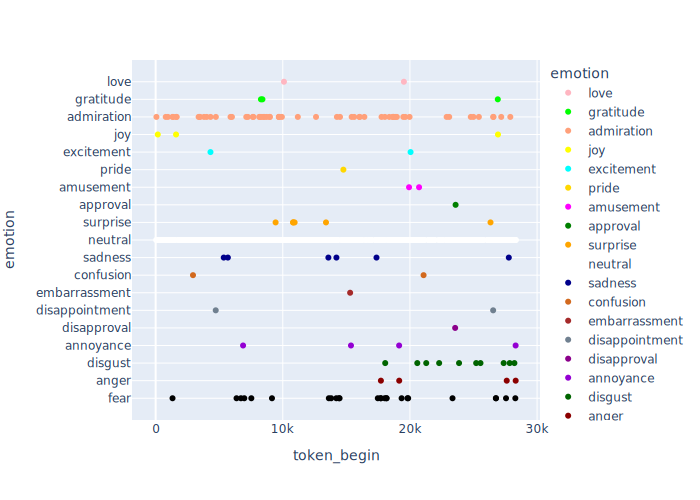

In [19]:
color_map = {
    "love": "lightpink",
    "gratitude":"lime", 
    "admiration":"lightsalmon",
    "joy": "yellow",
    
    "excitement":"cyan",
    'pride':"gold", 
    'amusement':"magenta",
    "approval":"green",
    'surprise':"orange",
    "neutral":"white",
    
    "sadness": "darkblue", 
    "confusion": "chocolate", 
    'embarrassment':"brown",
    "disappointment":"slategray", 
    'disapproval':"darkmagenta", 
    'annoyance':"darkviolet", 
    'disgust': "darkgreen", 
    "anger": "darkred", 
    "fear": "black"
}

df['emotion_number'] = df['emotion'].apply(lambda x: list(color_map).index(x))    
fig = px.scatter(df.sort_values(by=['emotion_number']) , y="emotion" ,x = 'token_begin' ,color='emotion'
                 ,color_discrete_map=color_map,hover_data=['token_begin'] )
fig.show()

Notice that we can see "spots" where the caracther has fear. Other points at the end of disgust and anger that it feels at the end of the journey. Joy it feels at the beginning and at the very end, at the same time it feels surprise and joy. Well surprise was just a little behind the joy and gratitude, so maybe it was surprise because it didn't expect something nice to him (latter he experience sadness as well, hope everything is ok :( ). The neutrality is his ability to describe events as they are, and he keept this capacity throughout the journey, with sprinkle of the other emotions. Others commonly ocurring emotion are: fear and admiration.

One interesting analysis can be to assest whether is more probable to have one emotion after another.

# Emotions precedding others

In [20]:
df.head()

,text,token_begin,emotion,emotion_number
0,next morning,40,neutral,9
1,wonderful place,62,admiration,2
2,correct time,110,neutral,9
3,splendid bridges,137,neutral,9
4,noble width,148,neutral,9


In [21]:
df['lag_emotion'] = df['emotion'].shift(1)
df.head()

,text,token_begin,emotion,emotion_number,lag_emotion
0,next morning,40,neutral,9,None
1,wonderful place,62,admiration,2,neutral
2,correct time,110,neutral,9,admiration
3,splendid bridges,137,neutral,9,neutral
4,noble width,148,neutral,9,neutral


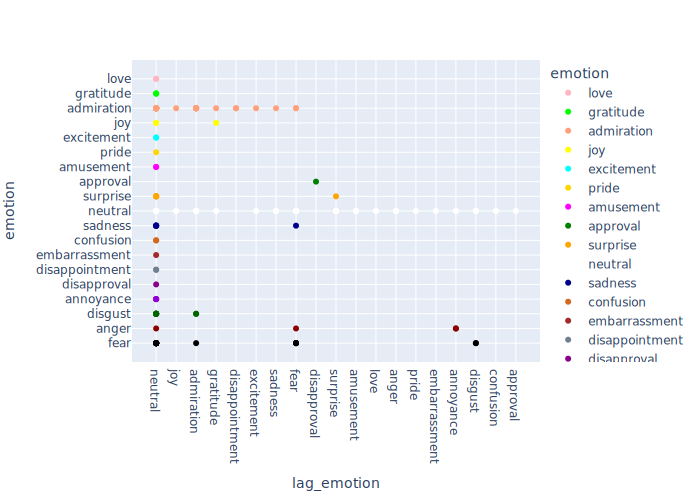

In [22]:
fig = px.scatter(df.sort_values(by=['emotion_number']) , y="emotion" ,x = 'lag_emotion' ,color='emotion'
                 ,color_discrete_map=color_map,hover_data=['token_begin'] )
fig.show()

The character after neutrality can come to whatever other emotion (looking the axis X). On the other hand, if we see that the character is now in a neutrality state, the previous state could be also whatever other state but dissapointment and disapproval (but we have just 2 points for those emotion so it is not saying much)

We are going to take out the neutrality to see more clearly how the character really feels...
The other thing we are going to do is to take into consideration how many times one emotion led to the other.

In [23]:
df_without_neu = df[df['emotion']!='neutral'].copy()
# we have to create again this lag emotion
df_without_neu['lag_emotion']= df_without_neu['emotion'].shift(1)
df_without_neu['lag_emotion_number']= df_without_neu['emotion_number'].shift(1)
df_without_neu['count'] = 1
df_group_emotions = df_without_neu[['emotion','lag_emotion','count']].groupby(['emotion','lag_emotion']).sum().reset_index()
df_group_emotions.head()

,emotion,lag_emotion,count
0,admiration,admiration,33
1,admiration,amusement,1
2,admiration,anger,1
3,admiration,annoyance,1
4,admiration,confusion,1


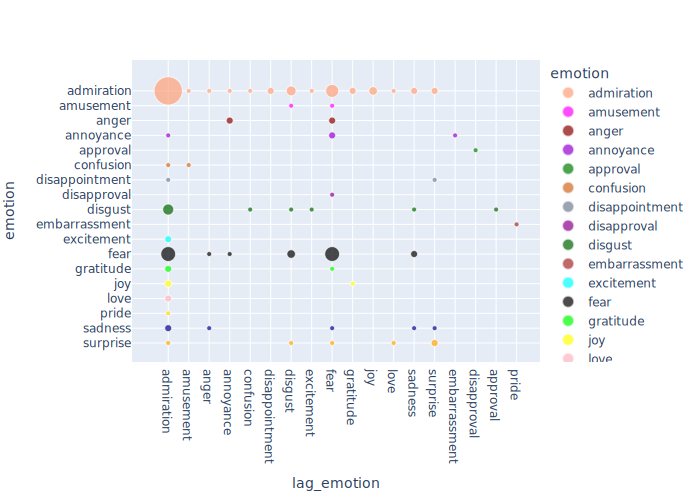

In [24]:
fig = px.scatter(df_group_emotions , y="emotion" ,x = 'lag_emotion' ,color='emotion',size='count'
                 ,color_discrete_map=color_map )
fig.show()

So, after admiration the character can feel a wide range of emotion afterwards. But generally it is follow by more admiration or fear, weirly other times it is sometimes follow by disgust. While the character is feeling fear it usually follow by more fear. It looks like fear and admiration are persistent emotions.
It is also interesting to notice that anger comes right after fear or annoyance. We have to little data to take this analysis very serious, but it is a good starting point to use this as a way to analyze the evolution of emotions in other books or text in general.

Maybe we can analyze a bigger portion from the book next time! 
**stayed tune!**